In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import glob
from pathlib import Path

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [4]:
def get_inputs(filepath):
    X = []
    for file in filepath:
        img = mpimg.imread(file)
        resized_img = cv2.resize(img, (64, 64))
        if len(resized_img.shape)!=3: #Some images have 3 identical channels instead of 1
            resized_img = np.stack((resized_img, resized_img, resized_img), axis=-1)

        X.append(resized_img)
    X = np.array(X)
    y=[]
    for file in filepath:
        if "NORMAL" in file:
            y.append(0)
        if "PNEUMONIA" in file:
            y.append(1)
    y = np.expand_dims(y, axis=-1)
    
    return X, y
def type_pred(list_true, list_pred):
    TP, FP, TN, FN = 0, 0, 0, 0
    for y_true, y_pred in zip(list_true, list_pred):
        if not y_true and not y_pred:
            TN+=1
        elif not y_true:
            FP+=1
        elif not y_pred:
            FN+=1
        else:
            TP+=1
    return TP, FP, TN, FN

def get_scores(list_true, list_pred):
    TP, FP, TN, FN = type_pred(list_true, list_pred)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1_score = 2*(precision*recall)/(precision+recall)
    return precision, recall, F1_score


In [7]:
filepath = glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/*/*')+glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/val/*/*')+glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/test/*/*')
X, y = get_inputs(filepath)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [8]:
print (X_train.shape, X_valid.shape, X_test.shape)
print (y_train.shape, y_valid.shape, y_test.shape)

(4684, 64, 64, 3) (586, 64, 64, 3) (586, 64, 64, 3)
(4684, 1) (586, 1) (586, 1)


In [9]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, GlobalAveragePooling2D, Dropout

model = Sequential()
conv_base = EfficientNetB0(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

model.add(conv_base)

model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

for layer in conv_base.layers:
    layer.trainable = False
    
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,055,972
Trainable params: 3,841
Non-trainable params: 4,052,131
_________________________________________________________________


In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

Path("save_models").mkdir(parents=True, exist_ok=True)

filepath = "save_models/effnet.h5"

callbacks = [ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1),
           EarlyStopping(monitor='val_accuracy', patience=10, verbose=1),
           ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, verbose=1)]

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-2),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/50
147/147 [==============================] - 27s 145ms/step - loss: 0.3844 - accuracy: 0.8620 - val_loss: 0.4312 - val_accuracy: 0.7747

Epoch 00001: val_accuracy improved from -inf to 0.77474, saving model to save_models/effnet.h5
Epoch 2/50
147/147 [==============================] - 19s 132ms/step - loss: 0.2686 - accuracy: 0.9133 - val_loss: 0.3308 - val_accuracy: 0.8532

Epoch 00002: val_accuracy improved from 0.77474 to 0.85324, saving model to save_models/effnet.h5
Epoch 3/50
147/147 [==============================] - 19s 129ms/step - loss: 0.2540 - accuracy: 0.9227 - val_loss: 0.2086 - val_accuracy: 0.9232

Epoch 00003: val_accuracy improved from 0.85324 to 0.92321, saving model to save_models/effnet.h5
Epoch 4/50
147/147 [==============================] - 19s 127ms/step - loss: 0.2553 - accuracy: 0.9202 - val_loss: 0.2069 - val_accuracy: 0.9317

Epoch 00004: val_accuracy improved from 0.92321 to 0.93174, saving model to save_models/effnet.h5
Epoch 5/50
147/147 [=======

In [12]:
from tensorflow.keras.models import load_model
model = load_model('save_models/effnet.h5')

for layer in model.layers[-20:]:#let's unfreeze some layers, the 20 last ones
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

filepath = "save_models/effnet_FT.h5"

callbacks = [ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1),
           EarlyStopping(monitor='val_accuracy', patience=10, verbose=1),
           ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, verbose=1)]


model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-3), #we reduce a bit the LR
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/50
147/147 [==============================] - 88s 539ms/step - loss: 0.4435 - accuracy: 0.8705 - val_loss: 0.6000 - val_accuracy: 0.7765

Epoch 00001: val_accuracy improved from -inf to 0.77645, saving model to save_models/effnet_FT.h5
Epoch 2/50
147/147 [==============================] - 78s 530ms/step - loss: 0.1449 - accuracy: 0.9478 - val_loss: 0.4439 - val_accuracy: 0.8191

Epoch 00002: val_accuracy improved from 0.77645 to 0.81911, saving model to save_models/effnet_FT.h5
Epoch 3/50
147/147 [==============================] - 77s 527ms/step - loss: 0.1061 - accuracy: 0.9608 - val_loss: 0.3659 - val_accuracy: 0.8618

Epoch 00003: val_accuracy improved from 0.81911 to 0.86177, saving model to save_models/effnet_FT.h5
Epoch 4/50
147/147 [==============================] - 77s 521ms/step - loss: 0.0731 - accuracy: 0.9676 - val_loss: 0.2247 - val_accuracy: 0.9181

Epoch 00004: val_accuracy improved from 0.86177 to 0.91809, saving model to save_models/effnet_FT.h5
Epoch 5/50
147/

In [13]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

model = load_model('save_models/effnet_FT.h5')

In [14]:
pred = model.predict(X_test)
y_pred = np.array([0 if val<0.5 else 1 for val in pred])
y_pred = np.expand_dims(y_pred, axis=-1)

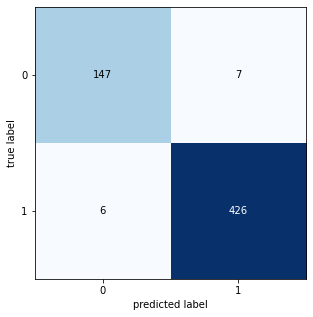

In [15]:
CM = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [33]:
TP=426
FP=7
FN=6
TN=147

In [16]:
precision, recall, F1_score = get_scores(y_test, y_pred)

print (f"recall = {recall:05f}")
print (f"precision = {precision:05f}")
print (f"F1_score = {F1_score:05f}")

recall = 0.986111
precision = 0.983834
F1_score = 0.984971


In [35]:
test_accuracy=(TP + TN)/(TP + TN + FP + FN)

In [36]:
print(test_accuracy)

0.9778156996587031
